## Trajectory Optimization of a Bouncing Ball

### The foot-deck contact - the normal and friction force

Explore how contact forces and discontinous dynamics can be handled in optimization. 

In [2]:
# import libraries
import sympy as sym
import numpy as np

sym.init_printing()
from IPython.display import display #for pretty printing

# DERIVE EOMS OF BOARD --------------------------------------------------------------------------------------------------------

# create symbolic variables
# system parameters
g = sym.symbols('g')
mb = sym.symbols('m_{ball}') # mass
hb = sym.symbols('h_{ball}') # height

# generalized coordinates
x, y = sym.symbols(['x','y']) 
dx, dy = sym.symbols(['\dot{x}','\dot{y}']) 
ddx, ddy = sym.symbols(['\ddot{x}','\ddot{y}']) 

# forces
Fcy, Fcx = sym.symbols(['F_{y}','F_{x}']) # impulsive impact force

EOMy = mb*ddy + mb*g - Fcy
EOMx = mb*ddx - Fcx

EOMx = EOMx.simplify()
EOMy = EOMy.simplify()
    
EOMs_ball = sym.Matrix([EOMx, EOMy])
    
#display(sym.solve(EOMs_ball,[ddx, ddy]))

In [3]:
# Lambdify EOMs
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

func_map = {'sin':sin, 'cos':cos} 

sym_list = [g,mb,
            x,y,dx,dy,ddx,ddy,
            Fcx, Fcy]

lambEOMx_ball = sym.lambdify(sym_list,EOMs_ball[0],modules = [func_map])
lambEOMy_ball = sym.lambdify(sym_list,EOMs_ball[1],modules = [func_map])

In [4]:
# import libraries
import sympy as sym
import numpy as np

sym.init_printing()
from IPython.display import display #for pretty printing

# DERIVE EOMS OF BOARD --------------------------------------------------------------------------------------------------------

# system parameters
g = sym.symbols('g')
mb = sym.symbols('m_{board}') # mass
lb = sym.symbols('l_{board}') # length
lbr = sym.symbols('l_{wheels}') # length to reaction forces
hb = sym.symbols('h_{board}') # height - board clearance
Inb = sym.symbols('In_{board}') # moment of intertia
rF_FF, rF_BF = sym.symbols(['r_{F_{FF}}','r_{F_{BF}}']) # distance of feet from COM. 

# generalized coordinates
x,y,thb = sym.symbols(['x','y','\\theta_{board}']) 
dx,dy,dthb = sym.symbols(['\dot{x}','\dot{y}','\dot{\\theta}_{board}']) 
ddx,ddy,ddthb = sym.symbols(['\ddot{x}','\ddot{y}','\ddot{\\theta}_{board}']) 

q = sym.Matrix([[x],[y],[thb]])
dq = sym.Matrix([[dx],[dy],[dthb]])
ddq = sym.Matrix([[ddx],[ddy],[ddthb]])

# forces
GRF_BW,GRF_FW = sym.symbols(['GRF_{BW}','GRF_{FW}']) # ground reaction forces
F_BFx,F_BFy = sym.symbols(['F_{BFx}','F_{BFy}']) # back foot applied forces
F_FFx,F_FFy = sym.symbols(['F_{FFx}','F_{FFy}']) # front foot applied forces

# STEP 1: position vectors ri = [x,y] (world frame)
rb = sym.Matrix([[x],
                [y]])
# the Jacobians
Jb = rb.jacobian(q)

# STEP 2: generate expressions for the system space velocities from the jacobians
vb = Jb*dq

# STEP 3: generate expressions for the kinetic and potential energy
# mass vectors
Mb = sym.Matrix([mb,mb])

T = 0.5*sym.transpose(Mb)*sym.matrix_multiply_elementwise(vb,vb)
T = T[0] + 0.5*Inb*dthb**2
V = mb*g*rb[1]

# STEP 4: calculate each term of the Lagrange equation
# term 1
Lg1 = sym.zeros(len(q),1)
for i in range(len(q)):
    dT_ddq = sym.Matrix([sym.diff(T,dq[i])]) # get partial of T in dq_i
    Lg1[i] = dT_ddq.jacobian(q)*dq + dT_ddq.jacobian(dq)*ddq #...then get time derivative of that partial

# term 3
Lg3 = sym.Matrix([T]).jacobian(q).transpose() # partial of T in q

# term 4
Lg4 = sym.Matrix([V]).jacobian(q).transpose() # partial of U in q

# term 5 - generalized forces
# applied forces
F_bf = sym.Matrix([[F_BFx*sym.cos(thb) + F_BFy*sym.sin(thb)],[F_BFx*sym.sin(thb) - F_BFy*sym.cos(thb)]])
F_ff = sym.Matrix([[F_FFx*sym.cos(thb) + F_FFy*sym.sin(thb)],[F_FFx*sym.sin(thb) - F_FFy*sym.cos(thb)]])

# ground forces acting on the board
GRF_bw = sym.Matrix([[0],[GRF_BW]])
GRF_fw = sym.Matrix([[0],[GRF_FW]])

# distance of forces
rGRF_bw = sym.Matrix([[x - 0.5*lbr*sym.cos(thb)+hb*sym.sin(thb)],
                      [y - 0.5*lbr*sym.sin(thb)-hb*sym.cos(thb)]])

rGRF_fw = sym.Matrix([[x + 0.5*lbr*sym.cos(thb)+hb*sym.sin(thb)],
                      [y + 0.5*lbr*sym.sin(thb)-hb*sym.cos(thb)]])

JGRF_bw = rGRF_bw.jacobian(q)
JGRF_fw = rGRF_fw.jacobian(q)

# applied forces on the board
rF_bf = sym.Matrix([[x - rF_BF*sym.cos(thb)],
                    [y - rF_BF*sym.sin(thb)]])

rF_ff = sym.Matrix([[x + rF_FF*sym.cos(thb)],
                    [y + rF_FF*sym.sin(thb)]])

JF_bf = rF_bf.jacobian(q)
JF_ff = rF_ff.jacobian(q)

Q = sym.zeros(len(q),1)
for j in range(len(q)):
    Q[j] = GRF_bw.transpose()*JGRF_bw[:,j]+GRF_fw.transpose()*JGRF_fw[:,j]+F_bf.transpose()*JF_bf[:,j]+F_ff.transpose()*JF_ff[:,j]

# Calculate equations of motion
EOM = Lg1 - Lg3 + Lg4 - Q

EOMs_board = sym.zeros(len(q),1)
for j in range(len(q)):
     EOMs_board[j] = EOM[j].simplify()

#display(sym.solve(EOMs, [ddq[0],ddq[1],ddq[2]]))


In [5]:
# Q.simplify()
# print(Q)

In [6]:
# Lambdify EOMs
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

func_map = {'sin':sin, 'cos':cos} 

sym_list = [g,mb,lb,lbr,Inb,hb,
            x,y,thb,
            dx,dy,dthb,
            ddx,ddy,ddthb,
            rF_BF,rF_FF,
            F_BFx,F_BFy,F_FFx,F_FFy,
            GRF_BW,GRF_FW]
            
lambEOMx_board   = sym.lambdify(sym_list,EOMs_board[0],modules = [func_map])
lambEOMy_board   = sym.lambdify(sym_list,EOMs_board[1],modules = [func_map])
lambEOMthb_board = sym.lambdify(sym_list,EOMs_board[2],modules = [func_map])

In [7]:
# rerun from here if you don't want to calculate the EOM's again
if 'm' in globals():
    del m # deletes the model
    
m = ConcreteModel()

# SETS-----------------------------------------------------------------------------------------------------------------------

N = 40
m.N = RangeSet(N)

hm  = 0.01 #master timestep

DOFs = ['x','y','thb','x_ball','y_ball'] # generalized coordinates
m.DOF = Set(initialize = DOFs) 

Fs = ['BFx','BFy','FFx','FFy'] # front foot, backfoot
m.Fs = Set(initialize = Fs) 

rFs = ['BF','FF'] # front foot, backfoot
m.rFs = Set(initialize = rFs) 

GRFs = ['BW','FW'] # front wheel, back wheel
m.GRFs = Set(initialize = GRFs)

bodies = ['ball','sb'] # front wheel, back wheel
m.bodies = Set(initialize = bodies)

# PARAMETERS-----------------------------------------------------------------------------------------------------------------

m.g = Param(initialize = 9.81) # gravity
m.mb = Param(initialize = 2.0) # mass of board
m.m_ball = Param(initialize = 10.0) # mass of ball
m.lb = Param(initialize = 0.80) # length of board
m.lbr = Param(initialize = 0.45) # length between wheels lb-(14.3+3)*2
m.hb = Param(initialize = 0.09) # board clearance

m.Inb = Param(initialize = 1/12*m.mb*m.lb**2) # moment of inertia about centre

# VARIABLES -----------------------------------------------------------------------------------------------------------------

# system coordinates
m.q = Var(m.N, m.DOF) # position
m.dq = Var(m.N, m.DOF) # velocity
m.ddq = Var(m.N, m.DOF) # acceleration

# auxillary variables
m.ptail = Var(m.N, m.DOF) # back of board
m.pnose = Var(m.N, m.DOF) # front of board
m.pbackwheel = Var(m.N, m.DOF) # position of backwheel
m.pfrontwheel = Var(m.N, m.DOF) # position of frontwheel
m.vtail = Var(m.N, m.DOF) # velocity of back of board
m.pball_b = Var(m.N, m.DOF) # position of ball in skateboard frame

def def_ptail(m,n,dof):
    if dof == 'x':
        return m.ptail[n, 'x'] == m.q[n,'x'] - 0.5*m.lb*cos(m.q[n,'thb'])
    if dof == 'y':
        return m.ptail[n, 'y'] == m.q[n,'y'] - 0.5*m.lb*sin(m.q[n,'thb']) 
    else:
        return Constraint.Skip
m.def_ptail = Constraint(m.N, m.DOF,rule = def_ptail)

def def_pnose(m,n,dof):
    if dof == 'x':
        return m.pnose[n, 'x'] == m.q[n,'x'] + 0.5*m.lb*cos(m.q[n,'thb'])
    if dof == 'y':
        return m.pnose[n, 'y'] == m.q[n,'y'] + 0.5*m.lb*sin(m.q[n,'thb']) 
    else:
        return Constraint.Skip
m.def_pnose = Constraint(m.N, m.DOF,rule = def_pnose)

def def_pbackwheel(m,n,dof):
    if dof == 'x':
        return m.pbackwheel[n, 'x'] == m.q[n,'x']-0.5*m.lbr*cos(m.q[n,'thb'])+m.hb*sin(m.q[n,'thb'])
    if dof == 'y':
        return m.pbackwheel[n, 'y'] == m.q[n,'y']-0.5*m.lbr*sin(m.q[n,'thb'])-m.hb*cos(m.q[n,'thb'])
    else:
        return Constraint.Skip
m.def_pbackwheel = Constraint(m.N, m.DOF,rule = def_pbackwheel)

def def_pfrontwheel(m,n,dof):
    if dof == 'x':
        return m.pfrontwheel[n, 'x'] == m.q[n,'x']+0.5*m.lbr*cos(m.q[n,'thb'])+m.hb*sin(m.q[n,'thb'])
    if dof == 'y':
        return m.pfrontwheel[n, 'y'] == m.q[n,'y']+0.5*m.lbr*sin(m.q[n,'thb'])-m.hb*cos(m.q[n,'thb'])
    else:
        return Constraint.Skip
m.def_pfrontwheel = Constraint(m.N, m.DOF,rule = def_pfrontwheel)

def def_vtail(m,n,dof):
    if dof == 'y':
        return m.vtail[n, 'y'] == m.dq[n,'y']-m.dq[n,'thb']*0.5*m.lb*cos(m.q[n,'thb'])
    else:
        return Constraint.Skip
m.def_vtail = Constraint(m.N, m.DOF,rule = def_vtail)

def def_pball_b(m,n,dof):
    if dof == 'x':
        return m.pball_b[n, 'x'] == (m.q[n,'x_ball'] - m.q[n,'x'])*cos(m.q[n,'thb']) + (m.q[n,'y_ball'] - m.q[n,'y'])*sin(m.q[n,'thb'])
    if dof == 'y':
        return m.pball_b[n, 'y'] == -(m.q[n,'x_ball'] - m.q[n,'x'])*sin(m.q[n,'thb']) + (m.q[n,'y_ball'] - m.q[n,'y'])*cos(m.q[n,'thb'])
    else:
        return Constraint.Skip
m.def_pball_b = Constraint(m.N, m.DOF,rule = def_pball_b)

# bound variables
for n in range(1,N+1):
    m.pnose[n,'y'].setlb(0.0)
    m.ptail[n,'y'].setlb(0.0)
    m.pbackwheel[n,'y'].setlb(0.0)
    m.pfrontwheel[n,'y'].setlb(0.0)
    m.q[n,'thb'].setub(np.pi/2)
    m.q[n,'thb'].setlb(-np.pi/2)
    m.pball_b[n,'y'].setlb(0.0)

# Constraints for ball and board contact --------------------------------------------------------------------------------------

    

In [8]:
# -----------------------------------------------------------------------------------------------------------------------------
# Contact Forces
# -----------------------------------------------------------------------------------------------------------------------------

# paramters
m.mu = Param(initialize = 0.5) # friction coefficient

# sign set for positive and negative components
signs = ['ps','ng'] 
m.sgn = Set(initialize = signs)

# forces
m.F = Var(m.N, m.Fs, m.sgn, bounds = (0.0, 50.0)) # Force from front and back foot > 0
m.F_b = Var(m.N, m.Fs, m.sgn, bounds = (0.0, 50.0)) # Force from front and back foot > 0
m.GRF = Var(m.N, m.GRFs, bounds = (0.0, 50.0)) # Ground reaction force on back wheel

def def_F(m,n,dof):
    if dof == 'x':
        return (m.F[n,'BFx','ps']-m.F[n,'BFx','ng']) == -((m.F_b[n,'BFx','ps'] - m.F_b[n,'BFx','ng'])*cos(m.q[n,'thb']) + (m.F_b[n,'BFy','ps'])*sin(m.q[n,'thb']))
    if dof == 'y':
        return (m.F[n,'BFy','ps']) == -((m.F_b[n,'BFx','ps'] - m.F_b[n,'BFx','ng'])*sin(m.q[n,'thb']) - (m.F_b[n,'BFy','ps'])*cos(m.q[n,'thb']))
    else:
        return Constraint.Skip
m.def_F = Constraint(m.N, m.DOF, rule = def_F)

In [9]:
# m.F.pprint()

In [10]:
ground_constraints = ['contact_BW','contact_FW']
m.ground_constraints = Set(initialize = ground_constraints) # set for indexing ground-related penalties
m.ground_penalty = Var(m.N, m.ground_constraints, bounds = (0.0,None))

contact_constraints = ['contact_Fy','contact_Fx', 'friction_BF','slip_x_ps','slip_x_ng']
m.contact_constraints = Set(initialize = contact_constraints) # set for indexing ground-related penalties
m.contact_penalty = Var(m.N, m.contact_constraints, bounds = (0.0,None))

# complemetarity of ground contact of wheels on ground  
def ground_contact(m,n,gc):
    if n < N:
        if gc == 'contact_FW':
            return m.ground_penalty[n,'contact_FW'] == m.pfrontwheel[n+1,'y']*m.GRF[n,'FW'] 
        if gc == 'contact_BW':
            return m.ground_penalty[n,'contact_BW'] == m.pbackwheel[n+1,'y']*m.GRF[n,'BW']
        else:
            return Constraint.Skip
    else:
        return Constraint.Skip
m.ground_contact = Constraint(m.N, m.ground_constraints, rule = ground_contact)

# friction stuff
m.friction_cone = Var(m.N, bounds = (0.0,None))
m.footv = Var(m.N, m.DOF, m.sgn, bounds = (0.0,100.0)) # foot velocity

def def_footv(m,n,dof):
    if dof == 'x':
        return m.footv[n,dof,'ps']-m.footv[n,dof,'ng'] == m.dq[n,'x_ball'] # this should be relative to the board.
    else:
        return Constraint.Skip
m.def_footv = Constraint(m.N, m.DOF, rule = def_footv)

def def_friction_cone(m,n):
    return m.friction_cone[n] == m.mu*m.F_b[n,'BFy','ps'] - (m.F_b[n,'BFx','ps'] + m.F_b[n,'BFx','ng'])
m.def_friction_cone = Constraint(m.N, rule = def_friction_cone)

# friction
def ground_friction(m,n):
    return m.contact_penalty[n,'friction_BF'] == (m.footv[n,'x','ps']+m.footv[n,'x','ng'])*m.friction_cone[n]
m.ground_friction = Constraint(m.N, rule = ground_friction)

# ball on board contact complemetarity  
def ball_contact(m,n,cc):
    if n < N:
        if cc == 'contact_Fy':
            return m.contact_penalty[n,'contact_Fy'] == m.pball_b[n+1,'y']*m.F[n,'BFy','ps']
        else:
            return Constraint.Skip
    else:
        return Constraint.Skip
m.ball_contact = Constraint(m.N, m.contact_constraints, rule = ball_contact)

# slipping of foot on board
def board_slip(m,n,cc): # the friction force must be applied in opposite direction to velocity of foot.
    if cc == 'slip_x_ps':
        return m.contact_penalty[n,'slip_x_ps'] == m.footv[n,'x','ps']*m.F_b[n,'BFx','ng']
    if cc == 'slip_x_ng':
        return m.contact_penalty[n,'slip_x_ng'] == m.footv[n,'x','ng']*m.F_b[n,'BFx','ps']
    else:
        return Constraint.Skip
m.board_slip = Constraint(m.N, m.contact_constraints, rule = board_slip)

for grf in GRFs:
    m.GRF[N, grf].fix(0.0)
for fs in Fs:
    for sgn in signs:
        m.F[N,fs,sgn].fix(0.0)
        m.F_b[N,fs,sgn].fix(0.0)
    
for fs in Fs:
    for sgn in signs:
        m.F[N, fs, sgn].fix(0.0)
    
for gnd in ground_constraints:
    m.ground_penalty[N, gnd].fix(0.0)

for cc in contact_constraints:
    m.contact_penalty[N, cc].fix(0.0)

In [11]:
# m.F_b.pprint()

In [12]:
# TIME AND INTEGRATION --------------------------------------------------------------------------------------------------------

# variable timestep
m.h = Var(m.N, bounds = (0.8,1.2))

# Integration constraints 
def BwEuler_p(m,n,dof): # for positions
    if n > 1:
        return m.q[n,dof] == m.q[n-1,dof] + hm*m.h[n]*m.dq[n,dof]
    else:
        return Constraint.Skip 
m.integrate_p = Constraint(m.N, m.DOF, rule = BwEuler_p)

def BwEuler_v(m,n,dof): # for velocities
    if n > 1:
        return m.dq[n,dof] == m.dq[n-1,dof] + hm*m.h[n]*m.ddq[n-1,dof]
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.DOF, rule = BwEuler_v)

# -----------------------------------------------------------------------------------------------------------------------------
# EOMs 
# -----------------------------------------------------------------------------------------------------------------------------
S = m.g*m.m_ball

# EOMs of skateboard
def EOMx_board(m,n):
    
    BFx_in = S*(m.F_b[n,'BFx','ps'] - m.F_b[n,'BFx','ng'])
    BFy_in = S*(m.F_b[n,'BFy','ps'])
    FFx_in = 0.0
    FFy_in = 0.0
    
    # list the model versions of all quantities in the same order as sym_list
    var_list = [m.g, m.mb, m.lb, m.lbr, m.Inb, m.hb, m.q[n,'x'], m.q[n,'y'], m.q[n,'thb'], 
               m.dq[n,'x'], m.dq[n,'y'], m.dq[n,'thb'], m.ddq[n,'x'], m.ddq[n,'y'], m.ddq[n,'thb'],
               -m.pball_b[n,'x'], 0.0,
               BFx_in, BFy_in, FFx_in, FFy_in, 
               S*m.GRF[n,'BW'], S*m.GRF[n,'FW']]
    return lambEOMx_board(*var_list) == 0
m.EOMx_board = Constraint(m.N, rule = EOMx_board)

def EOMy_board(m,n):
    
    BFx_in = S*(m.F_b[n,'BFx','ps'] - m.F_b[n,'BFx','ng'])
    BFy_in = S*(m.F_b[n,'BFy','ps'])
    FFx_in = 0.0
    FFy_in = 0.0
    
    # list the model versions of all quantities in the same order as sym_list
    var_list = [m.g, m.mb, m.lb, m.lbr, m.Inb, m.hb, m.q[n,'x'], m.q[n,'y'], m.q[n,'thb'], 
               m.dq[n,'x'], m.dq[n,'y'], m.dq[n,'thb'], m.ddq[n,'x'], m.ddq[n,'y'], m.ddq[n,'thb'],
               -m.pball_b[n,'x'], 0.0,
               BFx_in, BFy_in, FFx_in, FFy_in,  
               S*m.GRF[n,'BW'], S*m.GRF[n,'FW']]
    return lambEOMy_board(*var_list) == 0
m.EOMy_board = Constraint(m.N, rule = EOMy_board)

def EOMthb_board(m,n):
    
    BFx_in = S*(m.F_b[n,'BFx','ps'] - m.F_b[n,'BFx','ng'])
    BFy_in = S*(m.F_b[n,'BFy','ps'])
    FFx_in = 0.0
    FFy_in = 0.0
    
    # list the model versions of all quantities in the same order as sym_list
    var_list = [m.g, m.mb, m.lb, m.lbr, m.Inb, m.hb, m.q[n,'x'], m.q[n,'y'], m.q[n,'thb'], 
               m.dq[n,'x'], m.dq[n,'y'], m.dq[n,'thb'], m.ddq[n,'x'], m.ddq[n,'y'], m.ddq[n,'thb'],
               -m.pball_b[n,'x'], 0.0,
               BFx_in, BFy_in, FFx_in, FFy_in, 
               S*m.GRF[n,'BW'], S*m.GRF[n,'FW']] 
    return lambEOMthb_board(*var_list) == 0
m.EOMthb_board = Constraint(m.N, rule = EOMthb_board)

# EOMs of ball 
def EOMx_ball(m,n):
    
    BFx_in = S*(m.F[n,'BFx','ps'] - m.F[n,'BFx','ng'])
    BFy_in = S*(m.F[n,'BFy','ps'])
    
    # list the model versions of all quantities in the same order as sym_list
    var_list = [m.g, m.m_ball,
               m.q[n,'x_ball'], m.q[n,'y_ball'], m.dq[n,'x_ball'], m.dq[n,'y_ball'], m.ddq[n,'x_ball'], m.ddq[n,'y_ball'],
               BFx_in, BFy_in] 
    return lambEOMx_ball(*var_list) == 0
m.EOMx_ball = Constraint(m.N, rule = EOMx_ball)

def EOMy_ball(m,n):
    
    BFx_in = S*(m.F[n,'BFx','ps'] - m.F[n,'BFx','ng'])
    BFy_in = S*(m.F[n,'BFy','ps'])
    
    # list the model versions of all quantities in the same order as sym_list
    var_list = [m.g, m.m_ball,
               m.q[n,'x_ball'], m.q[n,'y_ball'], m.dq[n,'x_ball'], m.dq[n,'y_ball'], m.ddq[n,'x_ball'], m.ddq[n,'y_ball'],
               BFx_in, BFy_in] 
    return lambEOMy_ball(*var_list) == 0
m.EOMy_ball = Constraint(m.N, rule = EOMy_ball)

In [13]:
# COST FUNCTION ---------------------------------------------------------------------------------------------------------------

# minimum force and penalties
def CostFun(m):
    T = sum(m.h[n] for n in range(1,N+1))
    penalty_sum = 0
    for n in range(1,N+1):
        for gc in ground_constraints:
            penalty_sum += m.ground_penalty[n,gc]
        for cc in contact_constraints:
            penalty_sum += m.contact_penalty[n,cc]
    #return T+1000000*penalty_sum
    return 10000*penalty_sum
m.Cost = Objective(rule = CostFun)

In [14]:
# Drop ball on board

# INITIAL CONDITIONS
# The board
m.q[1,'x'].fix(0.0)
m.pbackwheel[1,'y'].fix(0.0)
m.q[1,'thb'].fix(0.0)

m.dq[1,'x'].fix(0.0)
m.dq[1,'y'].fix(0.0)
m.dq[1,'thb'].fix(0.0)

for n in range(1,N+1):
    for sgn in signs:
        m.F[n,'FFx',sgn].fix(0.0)
        m.F[n,'FFy',sgn].fix(0.0)
    
# The ball  
# m.pball_b[1,'x'].setub(-0.5*m.lbr)
# m.pball_b[1,'x'].setlb(-0.5*m.lb)
m.pball_b[1,'x'].fix(-0.6*m.lbr)
m.pball_b[1,'y'].fix(0.55)

m.dq[1,'y_ball'].fix(0.0)
m.dq[1,'x_ball'].fix(0.0)

# FINAL CONDITIONS
# m.ptail[N,'y'].fix(0.0)

In [15]:
# Solve -----------------------------------------------------------------------------------------------------------------------
opt = SolverFactory('ipopt',executable = 'C:/cygwin64/home/Nick/CoinIpopt/build/bin/ipopt.exe')
opt.options["linear_solver"] = 'ma86'
# opt = SolverFactory('ipopt') # standard issue, garden variety ipopt

# solver options
opt.options["expect_infeasible_problem"] = 'yes'
opt.options["print_level"] = 5 # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"] = 50000 # maximum number of iterations
opt.options["max_cpu_time"] = 10*60 # maximum cpu time in seconds
opt.options["Tol"] = 1e-6 # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.
    
results = opt.solve(m, tee=True) 

print(results.solver.status) # tells you if the solver had any errors/ warnings
print(results.solver.termination_condition) # tells you if the solution was (locally) optimal, feasible, or neither.

penalty_sum_ground = 0
penalty_sum_contact = 0
for n in range(1,N+1):
    for gc in ground_constraints:
        penalty_sum_ground += m.ground_penalty[n,gc].value
    for cc in contact_constraints:
        penalty_sum_contact += m.contact_penalty[n,cc].value    
print(penalty_sum_ground)
print(penalty_sum_contact)


Ipopt 3.12.9: linear_solver=ma86
expect_infeasible_problem=yes
print_level=5
max_iter=50000
max_cpu_time=600
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.9, running with linear solver ma86.

Number of nonzeros in equality constraint Jacobian...:     5467
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1127

Total number of variables............................:     1774
                     variables with only lower bounds:      511
                variables with lower and upper bounds:      470
                     variables with only up

In [16]:
maxForce = 0
maxFriction = 0
maxGRF = 0
for i in range(1,N+1):
    for sgn in signs:
        if m.F[i,'BFy',sgn].value is not None and m.F[i,'BFy',sgn].value>maxForce:
            maxForce = m.F[i,'BFy',sgn].value
        if m.F[i,'BFx',sgn].value is not None:
            if (m.F[i,'BFx','ps'].value - m.F[i,'BFx','ng'].value)>maxFriction:
                maxFriction = abs(m.F[i,'BFx','ps'].value - m.F[i,'BFx','ng'].value)
    for grf in GRFs:
        if m.GRF[i,grf].value is not None: 
            if m.GRF[i,grf].value>maxGRF:
                 maxGRF = m.GRF[i,grf].value

In [17]:
# m.Fs.pprint()

In [18]:
#m.q_ball.pprint()
#m.q_ball.pprint()
#print(0.5*m.lb)
#m.rF.pprint()

In [19]:
#animate it
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes
ax1.set_aspect('equal')

def plot_board(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-1,2])
    ax.set_ylim([-0.5,2.0])
    
    MARKER_SIZE = 6
    
    #plot ground
    groundLx = -1
    groundLy = 0
    groundRx = 2
    groundRy = 0
    ax.plot([groundLx,groundRx],[groundLy,groundRy],color='xkcd:black')
    
    #plot skateboard
    boardLx = m.ptail[i,'x'].value
    boardLy = m.ptail[i,'y'].value
    boardRx = m.pnose[i,'x'].value
    boardRy = m.pnose[i,'y'].value
    ax.plot([boardLx,boardRx],[boardLy,boardRy],color='xkcd:black')
    
    #plot left wheel
    leftwheelTopx = m.q[i,'x'].value-0.5*m.lbr*np.cos(m.q[i,'thb'].value)
    leftwheelTopy = m.q[i,'y'].value-0.5*m.lbr*np.sin(m.q[i,'thb'].value)
    leftwheelBottomx = m.pbackwheel[i,'x'].value
    leftwheelBottomy = m.pbackwheel[i,'y'].value
    ax.plot([leftwheelTopx,leftwheelBottomx],[leftwheelTopy,leftwheelBottomy],color='xkcd:black')
    
    #plot left wheel-wheel
    leftwheelx = m.q[i,'x'].value-0.5*m.lbr*cos(m.q[i,'thb'].value)+0.6*m.hb*sin(m.q[i,'thb'].value)
    leftwheely = m.q[i,'y'].value-0.5*m.lbr*sin(m.q[i,'thb'].value)-0.6*m.hb*cos(m.q[i,'thb'].value)
    ax.plot(leftwheelx,leftwheely,color='xkcd:black',marker = 'o',markersize=MARKER_SIZE)
    
    #plot right wheel
    rightwheelTopx = m.q[i,'x'].value+0.5*m.lbr*np.cos(m.q[i,'thb'].value)
    rightwheelTopy = m.q[i,'y'].value+0.5*m.lbr*np.sin(m.q[i,'thb'].value)
    rightwheelBottomx = m.pfrontwheel[i,'x'].value
    rightwheelBottomy = m.pfrontwheel[i,'y'].value
    ax.plot([rightwheelTopx,rightwheelBottomx],[rightwheelTopy,rightwheelBottomy],color='xkcd:black')
    
    #plot right wheel-wheel
    rightwheelx = m.q[i,'x'].value+0.5*m.lbr*cos(m.q[i,'thb'].value)+0.6*m.hb*sin(m.q[i,'thb'].value)
    rightwheely = m.q[i,'y'].value+0.5*m.lbr*sin(m.q[i,'thb'].value)-0.6*m.hb*cos(m.q[i,'thb'].value)
    ax.plot(rightwheelx,rightwheely,color='xkcd:black',marker = 'o',markersize=MARKER_SIZE)
    
    
    if maxForce!=0:
        magforceBFy = (m.F_b[i,'BFy','ps'].value)/maxForce
        magforceBFx = (m.F_b[i,'BFx','ps'].value-m.F_b[i,'BFx','ng'].value)/maxFriction
#         magforceBFy = 1
#         magforceBFx = 1
        
        #plot forces
        Xbackforcex = m.q[i,'x'].value + m.pball_b[i,'x'].value*cos(m.q[i,'thb'].value) + 0.5*magforceBFx*cos(m.q[i,'thb'].value)
        Xbackforcey = m.q[i,'y'].value+0.05 + m.pball_b[i,'x'].value*sin(m.q[i,'thb'].value) + 0.5*magforceBFx*sin(m.q[i,'thb'].value)
        Xdbackforcex = -0.5*magforceBFx*cos(m.q[i,'thb'].value)
        Xdbackforcey = -0.5*magforceBFx*sin(m.q[i,'thb'].value)

        Ybackforcex = m.q[i,'x'].value + m.pball_b[i,'x'].value*cos(m.q[i,'thb'].value) + 0.5*magforceBFy*sin(m.q[i,'thb'].value)
        Ybackforcey = m.q[i,'y'].value + m.pball_b[i,'x'].value*sin(m.q[i,'thb'].value) - 0.5*magforceBFy*cos(m.q[i,'thb'].value)
        Ydbackforcex = -0.5*magforceBFy*sin(m.q[i,'thb'].value)
        Ydbackforcey = 0.5*magforceBFy*cos(m.q[i,'thb'].value)
        
        ax.arrow(Xbackforcex, Xbackforcey, Xdbackforcex, Xdbackforcey, length_includes_head=True,head_width=magforceBFx*0.05,color='red')
        ax.arrow(Ybackforcex, Ybackforcey, Ydbackforcex, Ydbackforcey, length_includes_head=True,head_width=magforceBFy*0.05,color='red')
    
    #plot GRF's
    if (m.GRF[i,'BW'].value is not None) and (m.GRF[i,'BW'].value!=0.0):
        magGRFBW = m.GRF[i,'BW'].value/maxGRF
    else: 
        magGRFBW = 0
    if (m.GRF[i,'FW'].value is not None) and (m.GRF[i,'FW'].value!=0.0):
        magGRFFW = m.GRF[i,'FW'].value/maxGRF
    else: 
        magGRFFW = 0
        
    backGRFx = leftwheelBottomx
    backGRFy = leftwheelBottomy
    frontGRFx = rightwheelBottomx
    frontGRFy = rightwheelBottomy        

    ax.arrow(backGRFx, backGRFy-magGRFBW*0.5,0,magGRFBW*0.5, length_includes_head=True,head_width=magGRFBW*0.05,color='blue')
    ax.arrow(frontGRFx, frontGRFy-magGRFFW*0.5,0,magGRFFW*0.5, length_includes_head=True,head_width=magGRFFW*0.05,color='blue')
    
    #plot ball
    ballx = m.q[i,'x_ball'].value
    bally = m.q[i,'y_ball'].value  
    ax.plot(ballx,bally+0.05,color='xkcd:black', marker='o')

update = lambda i: plot_board(i,m,ax1) #lambdify update function

animate = ani.FuncAnimation(fig1, update, frames=range(1,N+1), interval=100, repeat=True)

plt.close(animate._fig)
HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook


In [20]:
# maxFriction

In [21]:
import matplotlib.pyplot as plt

h_ar1 = [m.h[i]() for i in range (1,N+1)]
h_ar1[0] = 0
h_ar1 = hm*np.cumsum(np.asarray(h_ar1))

def make_discrete_plots(m,i,count):
    
    plt.rcParams.update({'font.size': 25}) # change font size
    
    f = plt.figure(figsize=(4, 4));
    ax = f.add_subplot(111) #create axes
    ax.set_aspect('equal')
    
    ax.clear()
    ax.set_xlim([-0.55,0.5])
    ax.set_ylim([-0.5,0.5])

    MARKER_SIZE = 13

    #plot ground
    groundLx = -1
    groundLy = 0
    groundRx = 2
    groundRy = 0
#     ax.plot([groundLx,groundRx],[groundLy,groundRy],color='xkcd:black')

    #plot skateboard
    boardLx = m.ptail[i,'x'].value
    boardLy = m.ptail[i,'y'].value
    boardRx = m.pnose[i,'x'].value
    boardRy = m.pnose[i,'y'].value
    ax.plot([boardLx,boardRx],[boardLy,boardRy],color='xkcd:black')

    #plot left wheel
    leftwheelTopx = m.q[i,'x'].value-0.5*m.lbr*np.cos(m.q[i,'thb'].value)
    leftwheelTopy = m.q[i,'y'].value-0.5*m.lbr*np.sin(m.q[i,'thb'].value)
    leftwheelBottomx = m.pbackwheel[i,'x'].value
    leftwheelBottomy = m.pbackwheel[i,'y'].value
    ax.plot([leftwheelTopx,leftwheelBottomx],[leftwheelTopy,leftwheelBottomy],color='xkcd:black')

    #plot left wheel-wheel
    leftwheelx = m.q[i,'x'].value-0.5*m.lbr*cos(m.q[i,'thb'].value)+0.7*m.hb*sin(m.q[i,'thb'].value)
    leftwheely = m.q[i,'y'].value-0.5*m.lbr*sin(m.q[i,'thb'].value)-0.7*m.hb*cos(m.q[i,'thb'].value)
    ax.plot(leftwheelx,leftwheely,color='xkcd:black',marker = 'o',markersize=MARKER_SIZE)

    #plot right wheel
    rightwheelTopx = m.q[i,'x'].value+0.5*m.lbr*np.cos(m.q[i,'thb'].value)
    rightwheelTopy = m.q[i,'y'].value+0.5*m.lbr*np.sin(m.q[i,'thb'].value)
    rightwheelBottomx = m.pfrontwheel[i,'x'].value
    rightwheelBottomy = m.pfrontwheel[i,'y'].value
    ax.plot([rightwheelTopx,rightwheelBottomx],[rightwheelTopy,rightwheelBottomy],color='xkcd:black')

    #plot right wheel-wheel
    rightwheelx = m.q[i,'x'].value+0.5*m.lbr*cos(m.q[i,'thb'].value)+0.7*m.hb*sin(m.q[i,'thb'].value)
    rightwheely = m.q[i,'y'].value+0.5*m.lbr*sin(m.q[i,'thb'].value)-0.7*m.hb*cos(m.q[i,'thb'].value)
    ax.plot(rightwheelx,rightwheely,color='xkcd:black',marker = 'o',markersize=MARKER_SIZE)


    if maxForce!=0:
        magforceBFy = (m.F_b[i,'BFy','ps'].value)/maxForce
        magforceBFx = (m.F_b[i,'BFx','ps'].value-m.F_b[i,'BFx','ng'].value)/maxFriction
#         magforceBFy = 1
#         magforceBFx = 1
        
        #plot forces
        Xbackforcex = m.q[i,'x'].value + m.pball_b[i,'x'].value*cos(m.q[i,'thb'].value) + 0.25*magforceBFx*cos(m.q[i,'thb'].value)
        Xbackforcey = m.q[i,'y'].value+0.01 + m.pball_b[i,'x'].value*sin(m.q[i,'thb'].value) + 0.25*magforceBFx*sin(m.q[i,'thb'].value)
        Xdbackforcex = -0.25*magforceBFx*cos(m.q[i,'thb'].value)
        Xdbackforcey = -0.25*magforceBFx*sin(m.q[i,'thb'].value)

        Ybackforcex = m.q[i,'x'].value + m.pball_b[i,'x'].value*cos(m.q[i,'thb'].value) + 0.5*magforceBFy*sin(m.q[i,'thb'].value)
        Ybackforcey = m.q[i,'y'].value + m.pball_b[i,'x'].value*sin(m.q[i,'thb'].value) - 0.5*magforceBFy*cos(m.q[i,'thb'].value)
        Ydbackforcex = -0.5*magforceBFy*sin(m.q[i,'thb'].value)
        Ydbackforcey = 0.5*magforceBFy*cos(m.q[i,'thb'].value)
        
        ax.arrow(Xbackforcex, Xbackforcey, Xdbackforcex, Xdbackforcey, length_includes_head=True,head_width=abs(magforceBFx)*0.04,color='orange')
        ax.arrow(Ybackforcex, Ybackforcey, Ydbackforcex, Ydbackforcey, length_includes_head=True,head_width=magforceBFy*0.05,color='red')

    #plot GRF's
    if (m.GRF[i,'BW'].value is not None) and (m.GRF[i,'BW'].value!=0.0):
        magGRFBW = m.GRF[i,'BW'].value/maxGRF
    else: 
        magGRFBW = 0
    if (m.GRF[i,'FW'].value is not None) and (m.GRF[i,'FW'].value!=0.0):
        magGRFFW = m.GRF[i,'FW'].value/maxGRF
    else: 
        magGRFFW = 0

    backGRFx = leftwheelBottomx
    backGRFy = leftwheelBottomy
    frontGRFx = rightwheelBottomx
    frontGRFy = rightwheelBottomy        

    ax.arrow(backGRFx, backGRFy-magGRFBW*0.5,0,magGRFBW*0.5, length_includes_head=True,head_width=magGRFBW*0.05,color='blue')
    ax.arrow(frontGRFx, frontGRFy-magGRFFW*0.5,0,magGRFFW*0.5, length_includes_head=True,head_width=magGRFFW*0.05,color='blue')

    #plot ball
    ballx = m.q[i,'x_ball'].value
    bally = m.q[i,'y_ball'].value  
    ax.plot(ballx,bally+0.02,color='xkcd:black', marker='o')
    
    #plot time
    xtext = round(m.q[i,'x'].value,3) 
    ytext = -0.4
    txt = 't = ' + str(round(h_ar1[i-1],3)) +'s'
    ax.text(xtext, ytext, txt, horizontalalignment='center', fontsize=25)
    
    if count == 1:
        ax.axis('on')
    else:
        ax.axis('off')

In [22]:
# maxFriction

In [23]:
count = 1
Nplot = 33
Nplot_up = N
for n in range(Nplot,Nplot_up,1):
    make_discrete_plots(m,n,count)
    fig_name = 'plots\\ball_board_tilt\\ball_board_tilt_' + str(n) + '.png'
#     plt.savefig(fig_name, format='png')
    plt.close()
    count +=1

In [24]:
# m.F_b.pprint()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

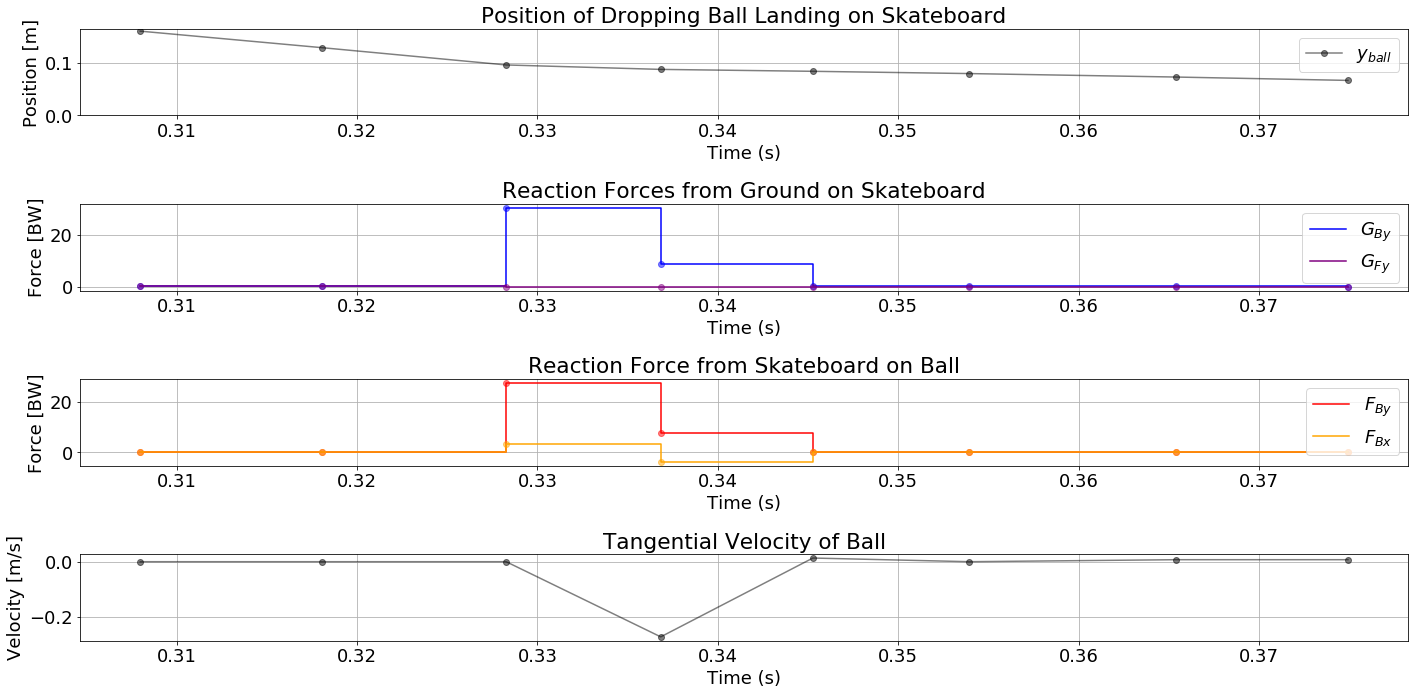

In [25]:
plt.rcParams.update({'font.size': 18}) # change font size

h_ar = h_ar1[Nplot-1:Nplot_up]

# Plot some of the variables
F_BFyar  = [m.F_b[i,'BFy','ps']()  for i in range(Nplot,Nplot_up+1)]
F_BFxar  = [(m.F_b[i,'BFx','ps']()-m.F_b[i,'BFx','ng']())  for i in range(Nplot,Nplot_up+1)]
GRF_BWar = [m.GRF[i,'BW']() for i in range(Nplot,Nplot_up+1)]
GRF_FWar = [m.GRF[i,'FW']() for i in range(Nplot,Nplot_up+1)]
vfoot_ar = [m.dq[i,'x_ball']() for i in range(Nplot,Nplot_up+1)]

qy_ar = [m.q[i,'y_ball']() for i in range(Nplot,Nplot_up+1)]

nar = np.linspace(1,N,N)

plt.figure(figsize=(20, 10))
plt.subplot(4,1,1)
plt.plot(h_ar, qy_ar, '-o', color='black', alpha=0.5)
plt.title('Position of Dropping Ball Landing on Skateboard')
plt.xlabel('Time (s)')
plt.ylabel('Position [m]')
plt.legend([r'$y_{ball}$'])
plt.grid(True)
plt.ylim([0.0,None])

plt.subplot(4,1,2)
plt.step(h_ar, GRF_BWar,where='post',color='blue',label = r'$G_{By}$')
plt.plot(h_ar, GRF_BWar, 'o', color='blue', alpha=0.5)
plt.step(h_ar, GRF_FWar,where='post',color='purple',label = r'$G_{Fy}$')
plt.plot(h_ar, GRF_FWar, 'o', color='purple',alpha=0.5)
plt.title('Reaction Forces from Ground on Skateboard')
plt.xlabel('Time (s)')
plt.ylabel('Force [BW]')
plt.legend()
plt.grid(True)

plt.subplot(4,1,3)
plt.step(h_ar, F_BFyar,where='post',color='red',label=r'$F_{By}$')
plt.plot(h_ar, F_BFyar, 'o', color='red', alpha=0.5)
plt.step(h_ar, F_BFxar,where='post',color='orange',label=r'$F_{Bx}$')
plt.plot(h_ar, F_BFxar, 'o', color='orange', alpha=0.5)
plt.title('Reaction Force from Skateboard on Ball')
plt.xlabel('Time (s)')
plt.ylabel('Force [BW]')
plt.legend(loc = 'upper right')
plt.grid(True)

plt.subplot(4,1,4)
plt.plot(h_ar, vfoot_ar, '-o', color='black', alpha=0.5)
plt.title('Tangential Velocity of Ball')
plt.xlabel('Time (s)')
plt.ylabel('Velocity [m/s]')
# plt.legend([r'$F_{BFy}$',r'$F_{BFx}$'])
plt.grid(True)

plt.tight_layout()

fig_name = 'plots\\ball_board_tilt\\board_ball_tilt_plots_' + str(n) + '.eps'
plt.savefig(fig_name, format='eps')
fig_name = 'plots\\ball_board_tilt\\board_ball_tilt_plots_' + str(n) + '.svg'
plt.savefig(fig_name, format='svg')

In [26]:
# plt.rcParams.keys()